# Lab: Applying TimeSeriesSplit with Custom Metrics on Monthly Data

**What you’ll do:**
- Generate the provided monthly dataset (trend + seasonality + noise)
- Define custom `mae_score` and `rmse_score` functions
- Use `show_splits` to study `TimeSeriesSplit` parameters
- Engineer lag/rolling features safely (avoid leakage)
- Train a model and evaluate per fold with your custom metrics
- Compare expanding vs sliding windows


## 1) Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge

# For reproducibility
rng = np.random.default_rng(42)

## 2) Custom metric functions (from user)

In [2]:
# --- Define custom metric functions ---
def mae_score(y_true, y_pred):
    """Mean Absolute Error"""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def rmse_score(y_true, y_pred):
    """Root Mean Squared Error"""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

## 3) Explore TimeSeriesSplit with `show_splits` (from user)

In [3]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

def show_splits(n_samples=20, **kw):
    X = np.arange(n_samples).reshape(-1, 1)
    tscv = TimeSeriesSplit(**kw)
    for i, (tr, te) in enumerate(tscv.split(X), 1):
        tr_preview = f"{tr[:3]}...{tr[-3:]}" if len(tr) > 6 else str(tr)
        print(f"Split {i:>2} | train={tr_preview} (len={len(tr)}) | test={te} (len={len(te)})")

print('Default (n_splits=5) on n=20')
show_splits(20, n_splits=5)
print('\nFixed test_size=3, n_splits=4')
show_splits(24, n_splits=4, test_size=3)
print('\nAdd a gap=2 to avoid leakage')
show_splits(24, n_splits=4, test_size=3, gap=2)

Default (n_splits=5) on n=20
Split  1 | train=[0 1 2 3 4] (len=5) | test=[5 6 7] (len=3)
Split  2 | train=[0 1 2]...[5 6 7] (len=8) | test=[ 8  9 10] (len=3)
Split  3 | train=[0 1 2]...[ 8  9 10] (len=11) | test=[11 12 13] (len=3)
Split  4 | train=[0 1 2]...[11 12 13] (len=14) | test=[14 15 16] (len=3)
Split  5 | train=[0 1 2]...[14 15 16] (len=17) | test=[17 18 19] (len=3)

Fixed test_size=3, n_splits=4
Split  1 | train=[0 1 2]...[ 9 10 11] (len=12) | test=[12 13 14] (len=3)
Split  2 | train=[0 1 2]...[12 13 14] (len=15) | test=[15 16 17] (len=3)
Split  3 | train=[0 1 2]...[15 16 17] (len=18) | test=[18 19 20] (len=3)
Split  4 | train=[0 1 2]...[18 19 20] (len=21) | test=[21 22 23] (len=3)

Add a gap=2 to avoid leakage
Split  1 | train=[0 1 2]...[7 8 9] (len=10) | test=[12 13 14] (len=3)
Split  2 | train=[0 1 2]...[10 11 12] (len=13) | test=[15 16 17] (len=3)
Split  3 | train=[0 1 2]...[13 14 15] (len=16) | test=[18 19 20] (len=3)
Split  4 | train=[0 1 2]...[16 17 18] (len=19) | test=

## 4) Data: Monthly series (provided)

In [12]:
periods = 300  # ~16.6 years of monthly data
date_index = pd.date_range('2008-01-01', periods=periods, freq='MS')
trend = np.linspace(10, 30, periods) + 0.1 * (np.arange(periods) ** 0.99)  # non-linear trend
seasonal = 5 * np.sin(2 * np.pi * (np.arange(periods) / 12))  # yearly seasonality
noise = rng.normal(0, 1.25, periods)  # noise
y = trend + seasonal + noise

df = pd.DataFrame({'date': date_index, 'y': y}).set_index('date')
df.head(30)

,y
date,
2008-01-01,12.159188
2008-02-01,10.749563
2008-03-01,15.742310
2008-04-01,15.086735
2008-05-01,14.915523
2008-06-01,12.010342
2008-07-01,10.572613
2008-08-01,10.279793
2008-09-01,7.716845


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2008-01-01 to 2032-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       300 non-null    float64
dtypes: float64(1)
memory usage: 4.7 KB


### Visualize series

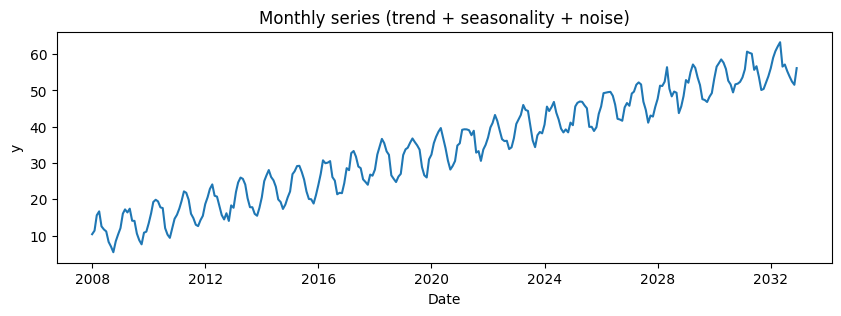

In [5]:
plt.figure(figsize=(10,3))
plt.plot(df.index, df['y'])
plt.title('Monthly series (trend + seasonality + noise)')
plt.xlabel('Date'); plt.ylabel('y')
plt.show()

## 5) Feature engineering (lags & rolling mean)
- Use lags up to 12 months to capture seasonality
- Add a 12‑month rolling mean (computed from past only)
- **Important:** Drop NaNs caused by shifting to align X and y correctly

In [6]:
MAX_LAG = 12
lagged = {f'lag_{i}': df['y'].shift(i) for i in range(1, MAX_LAG+1)}
roll_12 = df['y'].shift(1).rolling(window=12, min_periods=6).mean()

X = pd.concat([pd.DataFrame(lagged), roll_12.rename('roll12_mean')], axis=1)
y_series = df['y']

data = pd.concat([X, y_series.rename('y')], axis=1).dropna()
X = data.drop(columns=['y'])
y_aligned = data['y']

X.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,roll12_mean
date,,,,,,,,,,,,,
2009-01-01,10.281963,8.415254,5.416142,6.967525,8.259434,11.150483,11.698741,12.553385,16.673097,15.600589,11.366909,10.380896,10.730368
2009-02-01,12.055763,10.281963,8.415254,5.416142,6.967525,8.259434,11.150483,11.698741,12.553385,16.673097,15.600589,11.366909,10.869940
2009-03-01,16.045696,12.055763,10.281963,8.415254,5.416142,6.967525,8.259434,11.150483,11.698741,12.553385,16.673097,15.600589,11.259839
2009-04-01,17.214505,16.045696,12.055763,10.281963,8.415254,5.416142,6.967525,8.259434,11.150483,11.698741,12.553385,16.673097,11.394332
2009-05-01,16.389153,17.214505,16.045696,12.055763,10.281963,8.415254,5.416142,6.967525,8.259434,11.150483,11.698741,12.553385,11.370670


In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2009-01-01 to 2032-12-01
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lag_1        288 non-null    float64
 1   lag_2        288 non-null    float64
 2   lag_3        288 non-null    float64
 3   lag_4        288 non-null    float64
 4   lag_5        288 non-null    float64
 5   lag_6        288 non-null    float64
 6   lag_7        288 non-null    float64
 7   lag_8        288 non-null    float64
 8   lag_9        288 non-null    float64
 9   lag_10       288 non-null    float64
 10  lag_11       288 non-null    float64
 11  lag_12       288 non-null    float64
 12  roll12_mean  288 non-null    float64
dtypes: float64(13)
memory usage: 31.5 KB


## 6) Configure `TimeSeriesSplit`
- `n_splits=6` (six evaluation windows)
- `test_size=6` (6‑month forecast horizon)
- `gap=12` to guard against leakage from 12‑month lags/rolling features
- Start with expanding window (`max_train_size=None`), then compare sliding window

In [7]:
n_splits = 6
test_size = 24
gap = MAX_LAG
max_train_size = None

tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap=gap, max_train_size=max_train_size)

for i, (tr, te) in enumerate(tscv.split(X), 1):
    print(f"Split {i}: train_len={len(tr)}, test_len={len(te)}, train_end={X.index[tr][-1].date()}, test_start={X.index[te][0].date()}")

Split 1: train_len=132, test_len=24, train_end=2019-12-01, test_start=2021-01-01
Split 2: train_len=156, test_len=24, train_end=2021-12-01, test_start=2023-01-01
Split 3: train_len=180, test_len=24, train_end=2023-12-01, test_start=2025-01-01
Split 4: train_len=204, test_len=24, train_end=2025-12-01, test_start=2027-01-01
Split 5: train_len=228, test_len=24, train_end=2027-12-01, test_start=2029-01-01
Split 6: train_len=252, test_len=24, train_end=2029-12-01, test_start=2031-01-01


## 7) Train & evaluate per fold (Ridge)
Use your custom metrics for evaluation.

In [13]:
results = []
fold_preds = []
model = Ridge(alpha=1.0)

for i, (tr, te) in enumerate(tscv.split(X), 1):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y_aligned.iloc[tr], y_aligned.iloc[te]

    model.fit(X_tr, y_tr)
    y_hat = model.predict(X_te)

    mae = mae_score(y_te, y_hat)
    rmse = rmse_score(y_te, y_hat)

    fold_df = pd.DataFrame({'y_true': y_te.values, 'y_pred': y_hat}, index=y_te.index)
    fold_df['fold'] = i
    fold_preds.append(fold_df)

    results.append({
        'fold': i,
        'train_end': X_tr.index[-1],
        'test_start': X_te.index[0],
        'test_end': X_te.index[-1],
        'MAE': mae,
        'RMSE': rmse
    })

results_df = pd.DataFrame(results)
results_df

,fold,train_end,test_start,test_end,MAE,RMSE
0,1,2019-12-01,2021-01-01,2022-12-01,1.108547,1.376112
1,2,2021-12-01,2023-01-01,2024-12-01,1.302903,1.554539
2,3,2023-12-01,2025-01-01,2026-12-01,0.846858,1.118043
3,4,2025-12-01,2027-01-01,2028-12-01,1.557920,1.966202
4,5,2027-12-01,2029-01-01,2030-12-01,0.862745,1.200596
5,6,2029-12-01,2031-01-01,2032-12-01,1.113249,1.439980


### Summary table

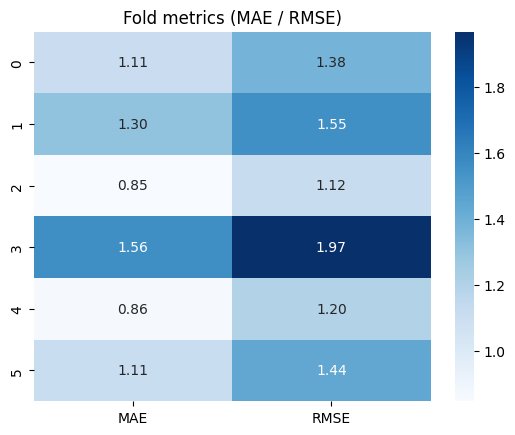

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(results_df[['MAE','RMSE']], annot=True, fmt=".2f", cmap="Blues")
plt.title("Fold metrics (MAE / RMSE)")
plt.show()


## 8) Visualize predictions vs actuals per fold

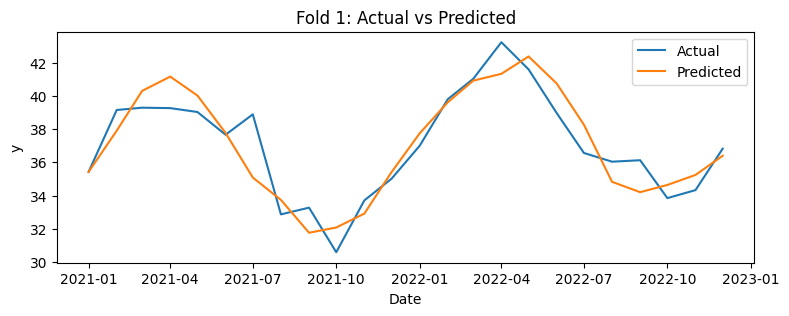

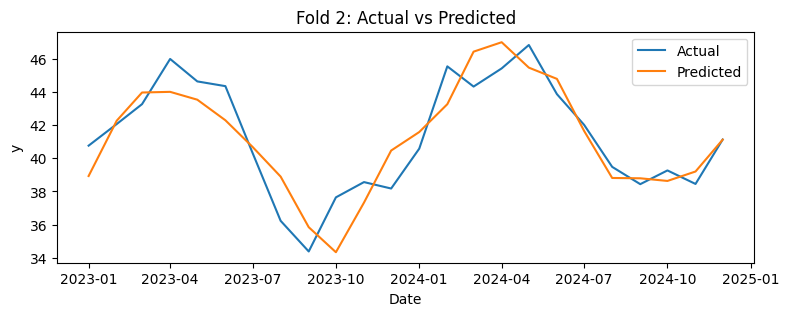

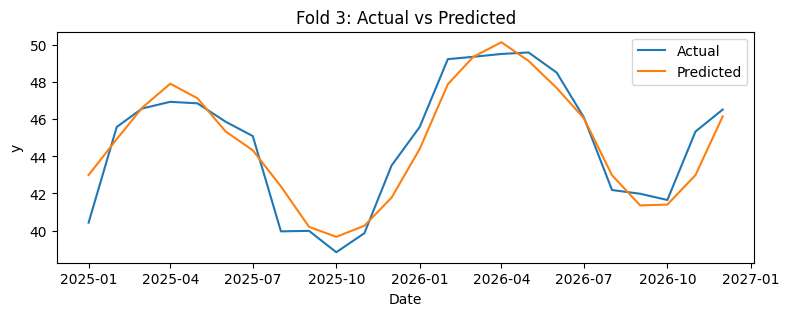

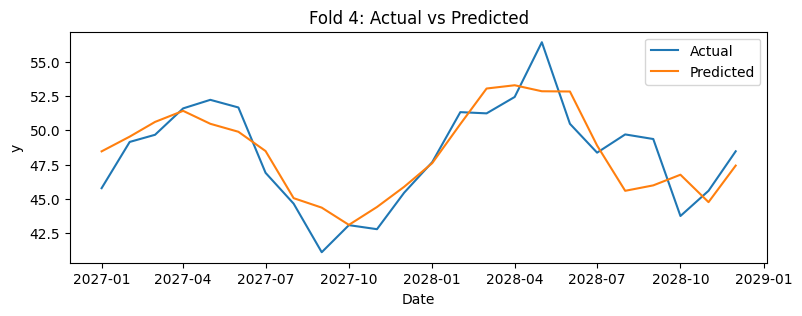

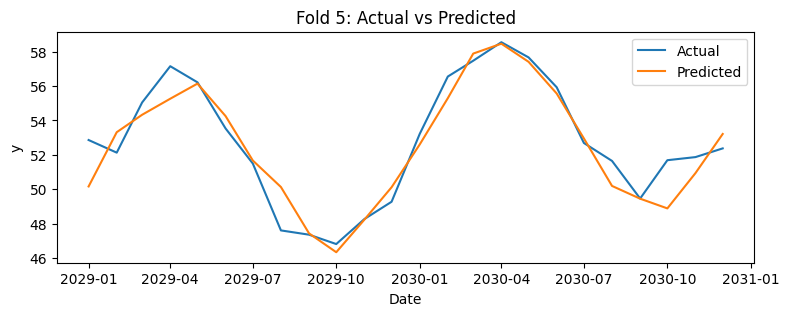

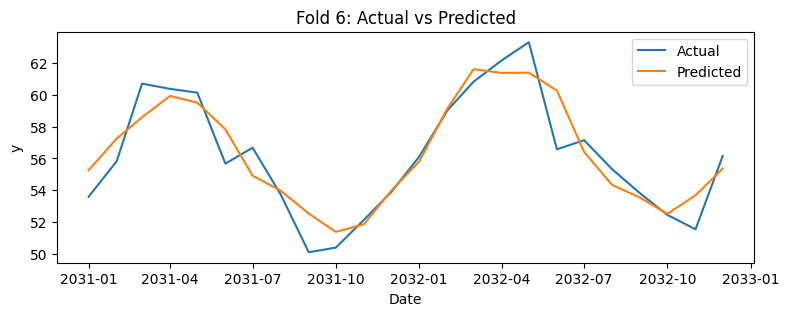

In [15]:
import pandas as pd
for i, g in pd.concat(fold_preds).groupby('fold'):
    plt.figure(figsize=(9,3))
    plt.plot(g.index, g['y_true'], label='Actual')
    plt.plot(g.index, g['y_pred'], label='Predicted')
    plt.title(f'Fold {i}: Actual vs Predicted')
    plt.xlabel('Date'); plt.ylabel('y')
    plt.legend()
    plt.show()

## 9) Variant: Sliding window with `max_train_size=60` (5 years)
Compare with expanding window using the same custom metrics.

In [16]:
tscv_sw = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap=gap, max_train_size=60)
results_sw = []
for i, (tr, te) in enumerate(tscv_sw.split(X), 1):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y_aligned.iloc[tr], y_aligned.iloc[te]
    model.fit(X_tr, y_tr)
    y_hat = model.predict(X_te)
    mae = mae_score(y_te, y_hat)
    rmse = rmse_score(y_te, y_hat)
    results_sw.append({'fold': i, 'MAE': mae, 'RMSE': rmse})

results_sw_df = pd.DataFrame(results_sw)
results_sw_df

,fold,MAE,RMSE
0,1,1.412973,1.577635
1,2,1.439179,1.702886
2,3,0.823155,1.042472
3,4,1.641161,2.026880
4,5,1.242699,1.625715
5,6,1.150201,1.440413


## 10) Compare expanding vs sliding

In [50]:
compare = results_df[['fold','MAE','RMSE']].merge(results_sw_df, on='fold', suffixes=('_expanding','_sliding'))
compare

,fold,MAE_expanding,RMSE_expanding,MAE_sliding,RMSE_sliding
0,1,1.108547,1.376112,1.412973,1.577635
1,2,1.302903,1.554539,1.439179,1.702886
2,3,0.846858,1.118043,0.823155,1.042472
3,4,1.557920,1.966202,1.641161,2.026880
4,5,0.862745,1.200596,1.242699,1.625715
5,6,1.113249,1.439980,1.150201,1.440413


## 11) Exercises
1. Change `test_size` to 12 months and re-run. How do MAE/RMSE change?
2. Set `gap=0` (unsafe with lags) and compare — do scores look too optimistic?
3. Swap in a different model (e.g., `LinearRegression` or `RandomForestRegressor`) and compare results.
4. Add calendar dummy features (month-of-year) and see if performance improves.